In [17]:
#hide
from autoneuro.calculators import TestCalculator
import pandas as pd
import numpy as np
import seaborn as sbn

# AutoNeuro

> A tool for calculating neurological scores based on demographically adjusted norms.

Due to the varied nature of these neurological tests it is often difficult to process these for research purposes.
This library is an attempt to standardize the test calculation and normalization.
At this point in development, it should not be used for diagnostic purposes.

## Install

`pip install git+https://github.com/JudoWill/autoneuro/`

## How to use

Currently the brief visiospatial memory tests has been implemented.
These are described in `yaml` files within the `data/` directory of the github repo.
Which look like:

In [4]:
!cat data/test_calculators/BVMT.yaml



name: 'Brief Visiospatial Memory Test'
short_name: 'BVMT'


operations:
  - type: equation
    equation: 'trial1+trial2+trial3'
    fields: ['trial1', 'trial2', 'trial3']
    out_field: immediate
  - type: agg
    method: 'max'
    fields: ['trial2', 'trial3']
    out_field: retention_denom
  - type: equation
    equation: 'delay/retention_denom'
    fields: [ 'delay', 'retention_denom']
    out_field: retention
  - type: clip
    field: retention
    lower: 0
    upper: 1
  - type: equation
    equation: 'hits-false_pos'
    fields: ['hits', 'false_pos']
    out_field: 'recognition'



In [6]:
import yaml

bvmt_config = yaml.full_load(open('data/test_calculators/BVMT.yaml'))
bvmt_calc = TestCalculator.from_config(bvmt_config)

Once created, this `TestCalculator` can be used to explain any set of calculations.

In [7]:
DATA = {'trial1': 5, 'trial2': 6, 'trial3': 7,
        'delay': 8, 'hits': 6, 'false_pos': 2,
        'copy': 12}

bvmt_calc.explain(DATA)

Taking: delay:8, false_pos:2, hits:6, trial1:5, trial2:6, trial3:7
Used Equation: trial1+trial2+trial3 = 18 = immediate
Aggregation: max [trial2, trial3]  = 7
Used Equation: delay/retention_denom = 1.1428571428571428 = retention
Clipped retention to [0, 1]
Used Equation: hits-false_pos = 4.0 = recognition
Resulting in: immediate:18.0, recognition:4.0, retention:1.0, retention_denom:7.0


These can then be combined with calculators that define age based norms (`heaton`) or regression norms (`norman`).

Like so:

In [9]:
heaton_norm_definition = 'data/norms/from_kate/heaton_bvmt.yaml'
heaton_bvmt_calc = TestCalculator.from_config(yaml.full_load(open(heaton_norm_definition)))

norman_scaling_definition = 'data/norms/norman/norman_scaling.yaml'
norman_scale = TestCalculator.from_config(yaml.full_load(open(norman_scaling_definition)))

norman_regression_definition = 'data/norms/norman/norman_bvmt_regnorm.yaml'
reg_calc = TestCalculator.from_config(yaml.full_load(open(norman_regression_definition)))

full_bvmt_calc = bvmt_calc + heaton_bvmt_calc + norman_scale + reg_calc

DATA = {'trial1': 5, 'trial2': 6, 'trial3': 7,
        'delay': 8, 'hits': 6, 'false_pos': 2,
        'copy': 12, 'age': 32, 'gender': 'male',
        'race': 'AA', 'education': 12}

full_bvmt_calc.explain(DATA)

Taking: age:32, delay:8, education:12, false_pos:2, gender:male, hits:6, race:AA, trial1:5, trial2:6, trial3:7
Used Equation: trial1+trial2+trial3 = 18 = immediate
Aggregation: max [trial2, trial3]  = 7
Used Equation: delay/retention_denom = 1.1428571428571428 = retention
Clipped retention to [0, 1]
Used Equation: hits-false_pos = 4 = recognition
heaton_immediate: Matched (30 <= age) & (age <= 33), Expecting 26.92 +- 4.64, Observed: 18
heaton_retention: Matched (30 <= age) & (age <= 33), Expecting 0.962 +- 0.0474, Observed: 1.0
heaton_delay: Matched (30 <= age) & (age <= 33), Expecting 10.13 +- 1.6, Observed: 8
heaton_recognition: Matched (30 <= age) & (age <= 33), Expecting 5.97 +- 0.15, Observed: 4
gender:male -> norman_gender:0
race:AA -> norman_race:1
delay matched 8, scaled to 7
immediate matched 16, scaled to 6
Matched (norman_race == 1) & ((age >= 18) & (age <= 66)), applied ((immediate_scaled-(0.2834*(education-13.86)+(-0.1125)*(age-40.63)+1.0394*norman_gender + 8.0679))/2.5701

These can also be run across `pd.DataFrame` objects.
This can be useful for either processning larger datasets or examing how one variable influences the score.

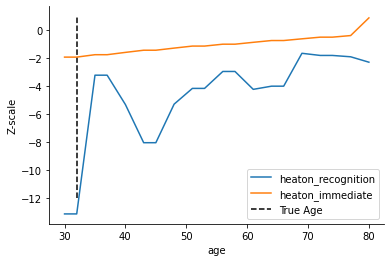

In [25]:
# Keep the same scores, but change the age.
df = pd.DataFrame([DATA]*20)
df['age'] = [int(age) for age in np.linspace(30, 80, 20)]

data = full_bvmt_calc.process_dataframe(df)
ax = data.plot(x = 'age', y = ['heaton_recognition',
                               'heaton_immediate'], ylabel = 'Z-scale')
ax.vlines(DATA['age'], -12, 1,
          linestyles='--',
          color = 'k',
          label = 'True Age')
ax.legend(loc = 'lower right')
sbn.despine(ax=ax)

From this graph we can see that for the `heaton` adjusted norms,
this test individual is well below age-adjusted norms for recognition.
With the same scores they would be considered impaired at any age.
However, their immediate recognition is only moderately impaired compared to age-adjusted norms.
